In [17]:
# pip list --format=freeze > requirements.txt
# pip install -r requirements.txt

In [18]:
%matplotlib inline

In [67]:
import torch
import pandas as pd
import os
from transformers import pipeline
from datetime import datetime

# from sklearn.svm import SVC
# from sklearn.datasets import load_digits
# from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

In [20]:
path = "/Users/emilygong/Desktop/RUW-Oil-Prediction/data"
os.chdir(path)

# Read in the Dataset

## News

In [21]:
guardian = pd.read_csv("Guardian_articles.csv")
guardian = guardian[['webPublicationDate', 'webTitle']]
guardian.columns = ['date', 'title']

nyt = pd.read_csv("NYT_articles.csv")
nyt = nyt[['pub_date', 'headline']]
nyt.columns = ['date', 'title']

In [22]:
def clean(string):
    main = string.find("'main':")
    comma = string.find("',")
    return string[main+9:comma+1]

nyt['title'] = nyt['title'].apply(clean)
nyt = nyt[nyt['title'] != '']

In [23]:
def select(string):
    return string[0:10]

guardian['date'] = guardian['date'].apply(select)
nyt['date'] = nyt['date'].apply(select)

In [24]:
final = pd.concat([guardian, nyt])

## Stock

In [25]:
oil_price = pd.read_csv("Oil_price.csv")
oil_price['date'] = pd.to_datetime(oil_price['date'])
oil_price = oil_price[oil_price['date'] >= datetime(2022, 2,1)]

oil_price_more = pd.read_csv("Oil_price.csv")


# Apply sentiment & Text/Emotion Classifier

In [124]:
sentiment = pipeline("sentiment-analysis", model = "distilbert-base-uncased-finetuned-sst-2-english")
classifier = pipeline("text-classification", model='bhadresh-savani/distilbert-base-uncased-emotion', top_k=None)

In [125]:
titles = final['title'].to_list()

label = []
score = []

anger = []
fear = []
joy = []
sadness = []
love = []
surprise = []

for title in titles:
    result = sentiment(title)
    label.append(result[0]['label'])
    score.append(result[0]['score'])
for title in titles:
    result = classifier(title)
    anger.append(result[0][0]['score'])
    fear.append(result[0][1]['score'])
    joy.append(result[0][2]['score'])
    sadness.append(result[0][3]['score'])
    love.append(result[0][4]['score'])
    surprise.append(result[0][5]['score'])

In [126]:
final['label'] = label
final['score'] = score

final['anger'] = anger
final['fear'] = fear
final['joy'] = joy
final['sadness'] = sadness
final['love'] = love
final['surprise'] = surprise

In [129]:
final['date'] = pd.to_datetime(final['date'])

In [26]:
# final.to_csv('final.csv', index = False)
final = pd.read_csv('final.csv')
final['date'] = pd.to_datetime(final['date'])

# Aggregate the News by Day

In [27]:
df_by_day = final.set_index("date").groupby(pd.Grouper(freq='D')).mean().reset_index()
# df_by_day = df_by_day.loc[df_by_day['date'] > datetime(2022, 3, 1)]

/var/folders/9f/07hlwdb51gggdsry0cqd7rdw0000gn/T/ipykernel_7074/1558793010.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_by_day = final.set_index("date").groupby(pd.Grouper(freq='D')).mean().reset_index()


In [28]:
df_by_day = df_by_day.dropna().reset_index(drop=True)
df_by_day = df_by_day[df_by_day['date'] >= datetime(2022, 2,1)]

In [29]:
df_by_day = df_by_day[['date', 'anger', 'fear', 'joy', 'sadness', 'love', 'surprise']]

In [30]:
price = pd.merge(df_by_day, oil_price, on = 'date')
price

date     anger      fear       joy   sadness      love  surprise  \
0   2022-02-01  0.818884  0.121842  0.041823  0.013718  0.002415  0.001318   
1   2022-02-02  0.834859  0.083082  0.047508  0.027382  0.004524  0.002645   
2   2022-02-03  0.768936  0.152720  0.057484  0.014726  0.004226  0.001908   
3   2022-02-04  0.773544  0.170671  0.030413  0.019233  0.003442  0.002697   
4   2022-02-07  0.795322  0.129422  0.049899  0.017454  0.005051  0.002852   
..         ...       ...       ...       ...       ...       ...       ...   
170 2022-10-05  0.710489  0.183579  0.070085  0.028213  0.004769  0.002865   
171 2022-10-06  0.748240  0.159685  0.058329  0.024821  0.005529  0.003396   
172 2022-10-07  0.772284  0.140320  0.054482  0.025421  0.004998  0.002496   
173 2022-10-10  0.817720  0.127242  0.034372  0.015086  0.003471  0.002110   
174 2022-10-11  0.821484  0.120525  0.038181  0.014804  0.003200  0.001806   

     price  
0    88.22  
1    88.16  
2    90.17  
3    92.27  
4    91.25  
..     ...  
170  88.22  
171  88.90  
172  93.07  
173  91.60  
174  89.75  

[175 rows x 8 columns]

# Simple Plots

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

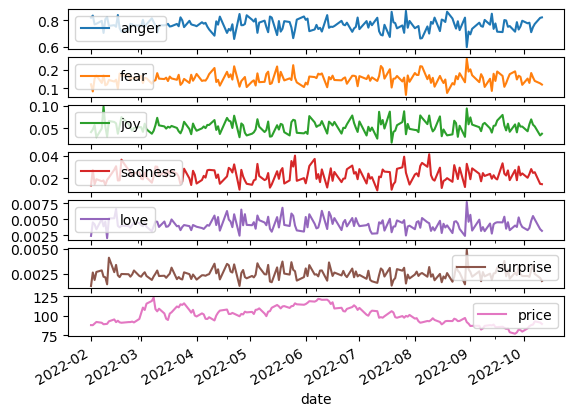

In [31]:
price = price.set_index('date')
price.plot(subplots=True)

In [34]:
price

anger      fear       joy   sadness      love  surprise  price
date                                                                         
2022-02-01  0.818884  0.121842  0.041823  0.013718  0.002415  0.001318  88.22
2022-02-02  0.834859  0.083082  0.047508  0.027382  0.004524  0.002645  88.16
2022-02-03  0.768936  0.152720  0.057484  0.014726  0.004226  0.001908  90.17
2022-02-04  0.773544  0.170671  0.030413  0.019233  0.003442  0.002697  92.27
2022-02-07  0.795322  0.129422  0.049899  0.017454  0.005051  0.002852  91.25
...              ...       ...       ...       ...       ...       ...    ...
2022-10-05  0.710489  0.183579  0.070085  0.028213  0.004769  0.002865  88.22
2022-10-06  0.748240  0.159685  0.058329  0.024821  0.005529  0.003396  88.90
2022-10-07  0.772284  0.140320  0.054482  0.025421  0.004998  0.002496  93.07
2022-10-10  0.817720  0.127242  0.034372  0.015086  0.003471  0.002110  91.60
2022-10-11  0.821484  0.120525  0.038181  0.014804  0.003200  0.001806  89.75

[175 rows x 7 columns]

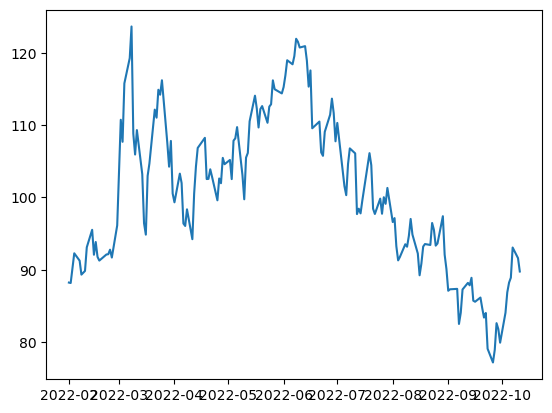

In [35]:
plt.plot('price', data = price)

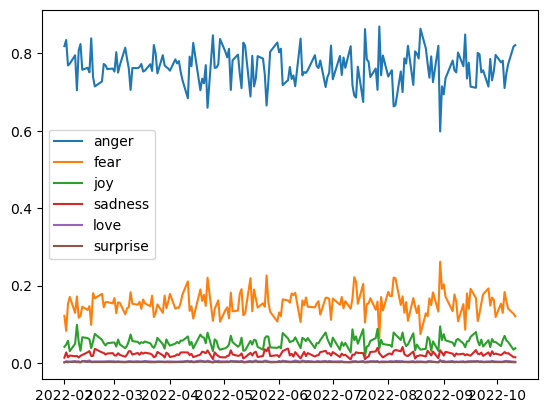

In [36]:
plt.plot('anger', data = price)
plt.plot('fear', data = price)
plt.plot('joy', data = price)
plt.plot('sadness', data = price)
plt.plot('love', data = price)
plt.plot('surprise', data = price)
plt.legend()

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

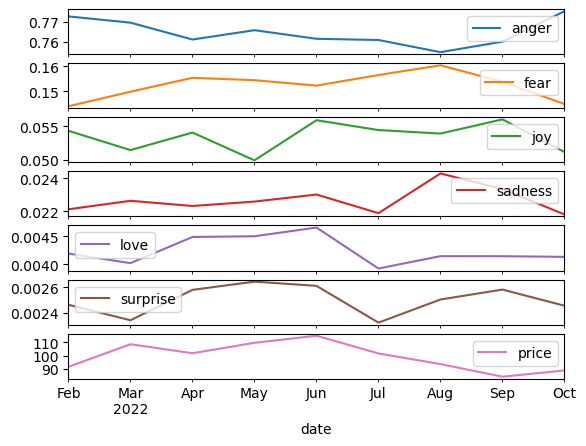

In [37]:
price_month = price.resample('M').mean()
price_month.plot(subplots=True)

# Stationary?

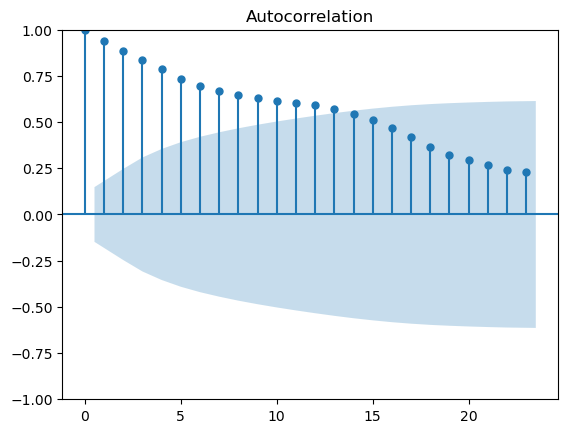

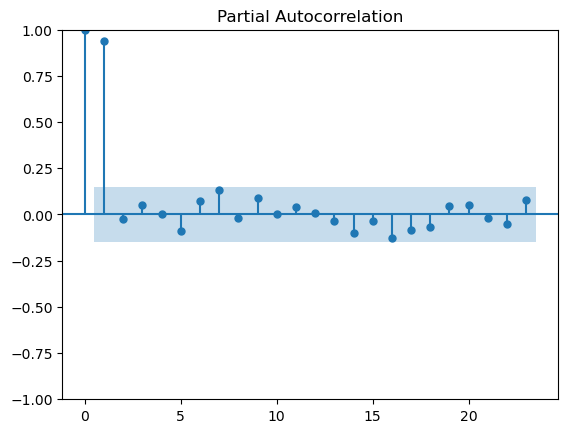

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(price['price'])
pacf_original = plot_pacf(price['price'], method='ywm')

The ACF plot shows the correlations with the lags are high and positive with very slow decay. While the PACF plot shows the partial autocorrelations have a single spike at lag 1. These are both signs of a trended time series. So our time series is not stationary.

In [39]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(price['price'])
print(f'p-value: {adf_test[1]}')

p-value: 0.21082065386222348


This result shows a large p-value, which means the test fails to reject the null hypothesis. So the ADF test also suggests that our time series is non-stationary.

# Transform to stationary

<AxesSubplot:xlabel='date'>

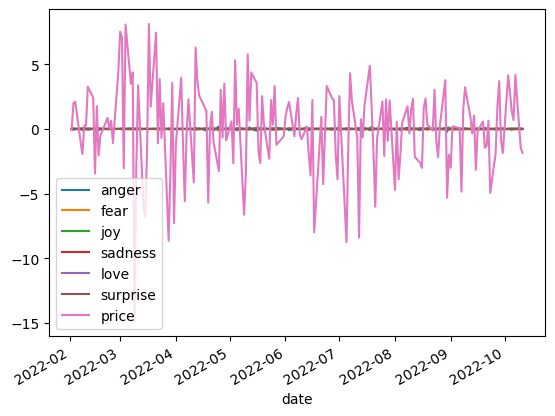

In [40]:
price_diff = price.diff().dropna()
price_diff.plot()

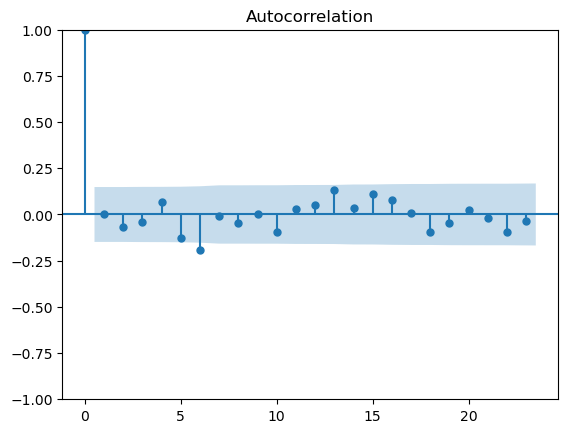

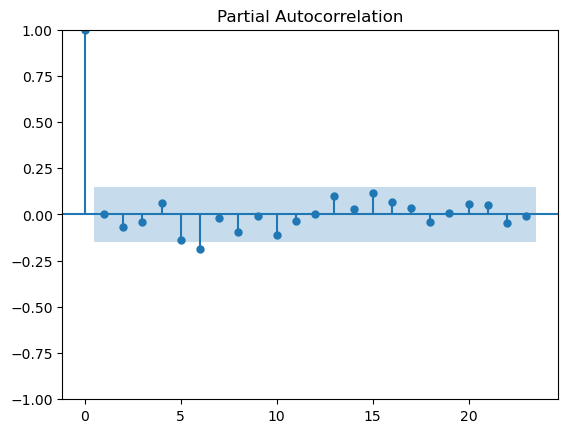

In [41]:
acf_diff = plot_acf(price_diff['price'])
pacf_diff = plot_pacf(price_diff['price'], method='ywm')

In [42]:
adf_test = adfuller(price_diff['price'])
print(f'p-value: {adf_test[1]}')

p-value: 7.394226640741658e-10


In [43]:
price_simple_ARIMA = price[['price']]
price_simple_ARIMA

price
date             
2022-02-01  88.22
2022-02-02  88.16
2022-02-03  90.17
2022-02-04  92.27
2022-02-07  91.25
...           ...
2022-10-05  88.22
2022-10-06  88.90
2022-10-07  93.07
2022-10-10  91.60
2022-10-11  89.75

[175 rows x 1 columns]

# Fit ARIMA

In [49]:
import pmdarima as pm
auto_arima = pm.auto_arima(price_simple_ARIMA, stepwise=True, seasonal=False)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  175
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -461.206
Date:                Fri, 25 Nov 2022   AIC                            924.411
Time:                        22:51:06   BIC                            927.571
Sample:                             0   HQIC                           925.693
                                - 175                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        11.7440      0.929     12.646      0.000       9.924      13.564
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                31.82
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Fit VARMAX

In [72]:
exog = price['price']
mod = sm.tsa.VARMAX(price[['anger', 'fear', 'joy', 'sadness', 'love', 'surprise']], order=(2,0), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
res.summary()

/Users/emilygong/opt/anaconda3/envs/torch/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/emilygong/opt/anaconda3/envs/torch/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                              Statespace Model Results                                             
===================================================================================================================
Dep. Variable:     ['anger', 'fear', 'joy', 'sadness', 'love', 'surprise']   No. Observations:                  175
Model:                                                             VARX(2)   Log Likelihood                4277.413
Date:                                                     Fri, 25 Nov 2022   AIC                          -8356.825
Time:                                                             23:26:48   BIC                          -8043.511
Sample:                                                                  0   HQIC                         -8229.736
                                                                     - 175                                         
Covariance Type:                                                       opg                                         
======================================================================================================================
Ljung-Box (L1) (Q):     0.02, 2.87, 0.05, 0.02, 0.03, 0.00   Jarque-Bera (JB):   0.20, 0.38, 5.61, 38.95, 11.26, 11.81
Prob(Q):                0.90, 0.09, 0.83, 0.90, 0.86, 0.96   Prob(JB):              0.91, 0.83, 0.06, 0.00, 0.00, 0.00
Heteroskedasticity (H): 1.52, 1.64, 1.43, 0.77, 1.11, 1.11   Skew:                -0.06, 0.11, 0.32, -0.62, 0.49, 0.14
Prob(H) (two-sided):    0.11, 0.06, 0.18, 0.32, 0.69, 0.69   Kurtosis:              3.12, 3.05, 3.59, 4.95, 3.76, 4.24
                           Results for equation anger                          
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.anger        0.5441      1.875      0.290      0.772      -3.130       4.218
L1.fear         0.4270      1.930      0.221      0.825      -3.356       4.210
L1.joy          0.5482      2.632      0.208      0.835      -4.610       5.706
L1.sadness      0.1869      3.406      0.055      0.956      -6.489       6.863
L1.love        13.7576      0.032    431.023      0.000      13.695      13.820
L1.surprise    -5.8382        nan        nan        nan         nan         nan
L2.anger        0.2055      1.867      0.110      0.912      -3.454       3.865
L2.fear        -0.2302      1.939     -0.119      0.906      -4.031       3.571
L2.joy          1.6024      2.514      0.637      0.524      -3.325       6.530
L2.sadness     -0.5118      3.345     -0.153      0.878      -7.068       6.044
L2.love        -4.5369      0.138    -32.768      0.000      -4.808      -4.266
L2.surprise    -7.0072        nan        nan        nan         nan         nan
beta.price      0.0005      0.001      0.395      0.693      -0.002       0.003
                           Results for equation fear                           
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.anger        0.3060      0.366      0.835      0.404      -0.412       1.024
L1.fear         0.3310      0.430      0.769      0.442      -0.513       1.175
L1.joy          0.4649      1.002      0.464      0.643      -1.499       2.429
L1.sadness      0.0771      1.765      0.044      0.965      -3.382       3.536
L1.love        -7.1406      0.787     -9.069      0.000      -8.684      -5.597
L1.surprise     2.8215      2.059      1.370      0.171      -1.214       6.857
L2.anger       -0.1759      0.355     -0.495      0.621      -0.873       0.521
L2.fear         0.1122      0.422      0.266      0.791      -0.716      

In [69]:
endog

dln_inv   dln_inc  dln_consump
qtr                                        
1960-04-01 -0.005571  0.030570     0.014355
1960-07-01  0.032970  0.042111     0.030411
1960-10-01  0.037139  0.016360     0.031749
1961-01-01  0.094363  0.031939     0.024257
1961-04-01 -0.043591  0.021381    -0.002181
...              ...       ...          ...
1977-10-01  0.026188  0.021032     0.017272
1978-01-01  0.025520  0.010843     0.012479
1978-04-01  0.035580  0.014599     0.018431
1978-07-01  0.025508  0.024339     0.013194
1978-10-01  0.036367  0.005173     0.005990

[75 rows x 3 columns]

In [64]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
dta = sm.datasets.webuse('lutkepohl2', 'https://www.stata-press.com/data/r12/')
dta.index = dta.qtr
dta.index.freq = dta.index.inferred_freq
endog = dta.loc['1960-04-01':'1978-10-01', ['dln_inv', 'dln_inc', 'dln_consump']]

In [66]:
exog = endog['dln_consump']
mod = sm.tsa.VARMAX(endog[['dln_inv', 'dln_inc']], order=(2,0), trend='n', exog=exog)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                             Statespace Model Results                             
Dep. Variable:     ['dln_inv', 'dln_inc']   No. Observations:                   75
Model:                            VARX(2)   Log Likelihood                 361.039
Date:                    Fri, 25 Nov 2022   AIC                           -696.078
Time:                            23:15:54   BIC                           -665.951
Sample:                        04-01-1960   HQIC                          -684.049
                             - 10-01-1978                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            0.05, 10.10   Jarque-Bera (JB):          11.21, 2.46
Prob(Q):                        0.83, 0.00   Prob(JB):                   0.00, 0.29
Heteroskedasticity (H):         0.45, 0.40   Skew:                      0.16, -0.38
Prob(H) (two-sided):            0.05, 0.03   Kurtosis:                   4.87, 3.45


In [51]:
#creating the train and validation set
train = price[:int(0.8*(len(price)))]
valid = price[int(0.8*(len(price))):]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

/Users/emilygong/opt/anaconda3/envs/torch/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


AttributeError: 'VARResults' object has no attribute 'y'

In [3]:
import pmdarima as pm

In [329]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(n_splits=8)

In [319]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]

# Gradient Boosting

In [300]:
from sklearn.experimental import enable_hist_gradient_boosting

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate

gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[],
        remainder="passthrough",
    ),
    HistGradientBoostingRegressor(),
)

In [301]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )


evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     15.906 +/- 2.177
Root Mean Squared Error: 16.820 +/- 2.293


## Naive Linear Regression

In [306]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
import numpy as np

naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[],
        remainder=MinMaxScaler(),
    ),
    Ridge(),
)


evaluate(naive_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     15.924 +/- 2.795
Root Mean Squared Error: 16.195 +/- 2.797


In [312]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
reg = Ridge(alpha=.5)
reg.fit(normalized_X, y)
reg.predit

[ 1.95922262 -0.28168914 -6.59739066 -0.31674863 16.09747549 -7.36006576]
98.58489397248164


# Feature Selection

# Reference

* https://www.justintodata.com/arima-models-in-python-time-series-prediction/
* https://www.section.io/engineering-education/multivariate-time-series-using-auto-arima/
* https://analyticsindiamag.com/a-guide-to-varma-with-auto-arima-in-time-series-modelling/